# Inicializações

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix"
    VISIBLE_GPUS = [7]

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())

os.chdir(BASE_PATH)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Running on Google Colab =  True


## Importe e instale as bibliotecas

Só faz sentido rodar isto daqui se você está no Google Colab, onde a máquina virtual é destruída quando você termina de usar o notebook e tem que repetir a instalação da próxima vez que usar.

Se estiver rodando no Jupyter em seu computador, você já deve ter configurado estas bibliotecas no seu ambiente Anaconda.

Caso não tenha configurado o Anaconda com fast.ai, execute esta célula **apenas uma vez**, se vier a rodar o notebook no seu computador mais vezes, não vai necessitar repetir esta célula. A instalação das bibliotecas será permanente.

In [2]:
INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install lapixdl
    !pip install -U albumentations
    !pip install fastai


Sempre execute esta célula, não importa se no seu computador ou no Colab. Ela vai importas as bibliotecas para dentro da máquina virtual do notebook.

In [3]:
import random
from pathlib import Path

import albumentations as A
import numpy as np
import pandas as pd
from fastai.vision.all import *
from lapixdl.evaluation.evaluate import evaluate_classification
from lapixdl.evaluation.model import Classification

# Fix seed
random.seed(81615)

## Definição de Funções Utilitárias

### Função para realizar transformações aleatórias nas imagens para aumentação de dados de maneira sintética.

In [4]:
class AlbumentationsTransform(Transform):
    split_idx = 0

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

## Conecte o seu Google Drive

Se você deseja carregar um **conjunto de dados cutomizado** seu e ele está no seu Google Drive ou então você deseja **salvar os resultados deste notebook depois da execução**, utilize esta célula aqui para conectar o notebook ao Drive.  Ele será montado na pasta "gdrive" do Colab. Nesta pasta vai aparecer todo o conteúdo do seu Google Drive.  

In [5]:
from google.colab import drive
import os
drive.mount(os.path.join(BASE_PATH, "gdrive"), force_remount=True)
DRIVE_BASE_PATH = os.path.join(BASE_PATH, "gdrive")

Mounted at /content/gdrive


# Configuração dos Paths e Metadados e Carga dos Conjuntos de Dados

Preenchemos os paths de acordo com a estrutura do dataset e os diretórios de output

Este notebook oferece 3 opções de carga de conjuntos de dados de treinamento. Escolha a sua de acordo com a disciplina na qual você estiver usando o notebook ou dos objetivos do seu trabalho.

##DATASET CUSTOM


In [6]:
path_dataset = Path("/content/gdrive/MyDrive/flowers-classification")
path_img = (
    path_dataset / "Path Imagens"
)  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = Path("Path Output")
path_models = (
    path_output / "Models"
)  # Folder where the models/weights should be saved in

path_models.mkdir(parents=True, exist_ok=True)

\


### Função auxiliar para gerar um subset com 'n' números de imagens. Neste notebook o seu propósito é em auxiliar na divisão dos conjuntos de treino, teste e validação.


In [7]:
import shutil
import random
def random_sample_images(dirpath, destfolder, nimages):
  files_list = os.listdir(dirpath)
  for filename in random.sample(files_list, nimages):
    shutil.copy(os.path.join(dirpath, filename), os.path.join(destfolder, filename))


### Criar os diretórios onde os dados estarão de acordo com o formato esperado e realizar a separação nos conjuntos de treino, teste e validação com sua devida proporção e para seus diretórios previamente criados.


In [38]:
PATH_DATASET = os.path.join(BASE_PATH, "dataset")
PATH_TRAIN = os.path.join(PATH_DATASET, "train")
PATH_VAL = os.path.join(PATH_DATASET, "val")
PATH_TEST = os.path.join(PATH_DATASET, "test")
os.makedirs(PATH_DATASET, exist_ok=True)
os.makedirs(PATH_TRAIN, exist_ok=True)
os.makedirs(PATH_VAL, exist_ok=True)
os.makedirs(PATH_TEST, exist_ok=True)
os.chdir(os.path.join(BASE_PATH, "gdrive/MyDrive/flowers-classification"))
dirnames = os.listdir('.')
datadict = {}
flower_class_allowed = ["daisy", "rose", "sunflower", "tulip", "dandelion", "coreopsis", "daffodil", "carnation", "bellflower", "magnolia"]
for dir_name in dirnames:
  if dir_name not in flower_class_allowed:
    continue
  os.makedirs(os.path.join(PATH_TRAIN,dir_name), exist_ok=True)
  os.makedirs(os.path.join(PATH_VAL,dir_name), exist_ok=True)
  os.makedirs(os.path.join(PATH_TEST,dir_name), exist_ok=True)
  datadict[dir_name] = len([fname for fname in os.listdir(os.path.join(dir_name,'.')) if os.path.isfile(os.path.join(dir_name,fname))])

train_rate = 0.8 # proporção dos arquivos que serão utilizados para treino - 80%
val_rate = 0.1 # proporção dos arquivos que serão utilizados para validação - 10%
test_rate = 0.1 # proporção dos arquivos que serão utilizados para teste - 10%
for key in datadict:
  images_to_train = int(datadict[key] * train_rate)
  images_to_val = int(datadict[key] * val_rate)
  images_to_test = int(datadict[key] * test_rate)
  print(key)
  random_sample_images(key, os.path.join(PATH_TRAIN, key), images_to_train)
  random_sample_images(key, os.path.join(PATH_VAL, key), images_to_val)
  random_sample_images(key, os.path.join(PATH_TEST, key), images_to_test)
os.chdir(BASE_PATH)

print(datadict)

magnolia
carnation
daffodil
bellflower
dandelion
rose
daisy
coreopsis
sunflower
tulip
{'magnolia': 289, 'carnation': 299, 'daffodil': 252, 'bellflower': 300, 'dandelion': 302, 'rose': 108, 'daisy': 300, 'coreopsis': 320, 'sunflower': 242, 'tulip': 262}


### Definir o caminho base do conjunto de dados, o caminho de saída da rede e o prefixo de nomeclatura dos pesos do modelo.


#CNN Model

*   resnet18, resnet34, resnet50, resnet101, resnet152
*   squeezenet1_0, squeezenet1_1
*   densenet121, densenet169, densenet201, densenet161
*   vgg16_bn, vgg19_bn
*   alexnet

Uma lista completa de modelos disponível em: https://github.com/fastai/fastai/tree/2.5.3/fastai/vision/models

In [41]:
from fastai.vision.models import resnet50

used_model = resnet50

## Train pipeline setup

### Pipeline

In [40]:
import albumentations as A
# Gerar aumentação de dados sintéticos
augmentations = A.Compose(
    [
        A.Resize(height=244, width=244, p=1),
        A.HorizontalFlip(p=0.5),
        A.Rotate((-10, 10), p=0.75),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
        A.Affine(p=0.75, shear=0.2)
    ]
)

transforms = [AlbumentationsTransform(augmentations)]

In [42]:
import os

folder = "/content/dataset"

for filename in os.listdir(folder):
    for filename2 in os.listdir("/content/dataset/" + filename):
      if filename.endswith(".git"):
        continue
      full_path = os.path.join(folder, filename)
      if os.path.isfile(full_path) and not filename.endswith(".jpg"):
          new_name = full_path + ".jpg"
          os.rename(full_path, new_name)

In [43]:
# Definir o array das métricas
metrics = [
    accuracy,
    F1Score(average="macro"),
    Precision(average="macro"),
    Recall(average="macro"),
]

#Carregando o Dataloader

Abaixo há dois métodos diferentes de carregar o dataset para dentro do dataloader da rede neural. Ambos vão funcionar:

* Pandas é uma biblioteca de visualização de dados em matriz e oferece rotinas de carga
* Há também as rotinas d ecarga ntivas do fast.ai qque você pode usarde froma simples.

In [44]:
# Defina o tamanho do seu lote de imagens para processamento pela rede
bs = 8
path_dataset = Path(PATH_DATASET)
# Carregue os dados usando função nativa do fast.ai
data = ImageDataLoaders.from_folder(path_dataset, train='train', valid='val', test=Path(os.path.join(PATH_DATASET, "test"))
                                    ,bs=bs,item_tfms=Resize(244),
                                    batch_tfms=[*aug_transforms(size=244), Normalize.from_stats(*imagenet_stats)],)

#Definindo Learner
Carregar as inicializações básicas para o aprendizado e definição dos parâmetros básicos da rede.

In [45]:
def get_learner(data, load_model=None, unfreeze:bool=False):
  """Creates and setups the learner for each step of the training approach.

  Args:
      data: Dataloader.
      load_model (str): Path to the model to be loaded.
      unfreeze (bool): Indicates if the model should be unfreezed. Defaults to False.
  """
  learn = vision_learner(data,
                      used_model,
                      metrics=metrics,
                      loss_func=CrossEntropyLossFlat()).to_fp16()

  learn.path = path_models
  if(load_model != None):
    learn.load(load_model)
  if(unfreeze):
    learn.unfreeze()
  return learn

# Treinamento Inicial: Transfer Learning


## Visualizando um batch do conjunto de dados

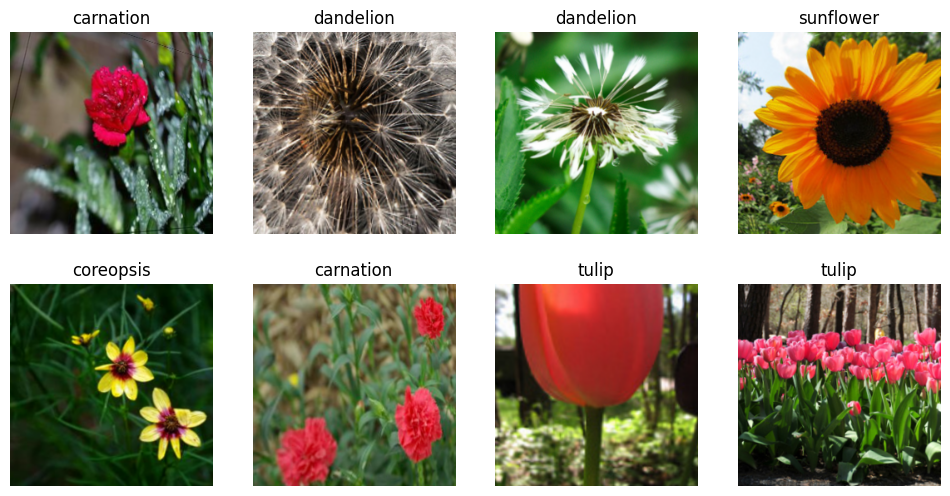

In [48]:
data.show_batch()

## Procurar a melhor taxa de aprendizado utilizando o método 'built-in' do fast.ai

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


SuggestedLRs(valley=0.0014454397605732083)

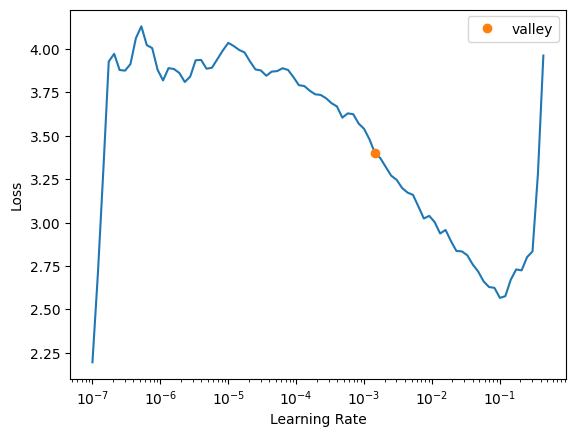

In [49]:
# Runs the learning rate finder
get_learner(data).lr_find()

Better model found at epoch 0 with f1_score value: 0.8491674997708152.


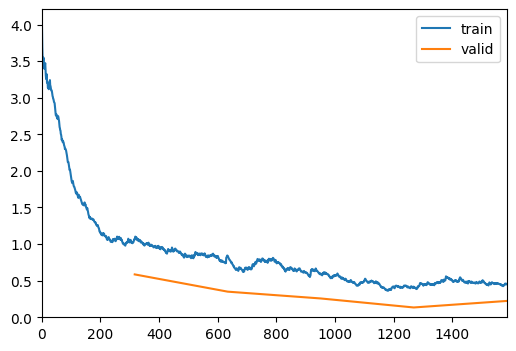

Better model found at epoch 1 with f1_score value: 0.8656790032221743.
Better model found at epoch 2 with f1_score value: 0.9276773140224224.
Better model found at epoch 3 with f1_score value: 0.9580495425277242.


In [50]:
import torch
import numpy
import functools

lr = slice(2e-3)  # Incluir aqui a taxa de aprendizado encontrada no passo anterior
wd = 1e-2  # decaimento da rede
TRAIN_EPOCH = 5
learn = get_learner(data)
callbacks = [
    SaveModelCallback(
        monitor="f1_score", fname="best_model_stg1", with_opt=False
    ),  # Saves the best model as `fname` in `learn.path` considering the metric defined in `monitor`.
    ShowGraphCallback(),  # Shows the train/validation graph
]

# Train
learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callbacks)

## Mostrar Resultados do Transfer Learning

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


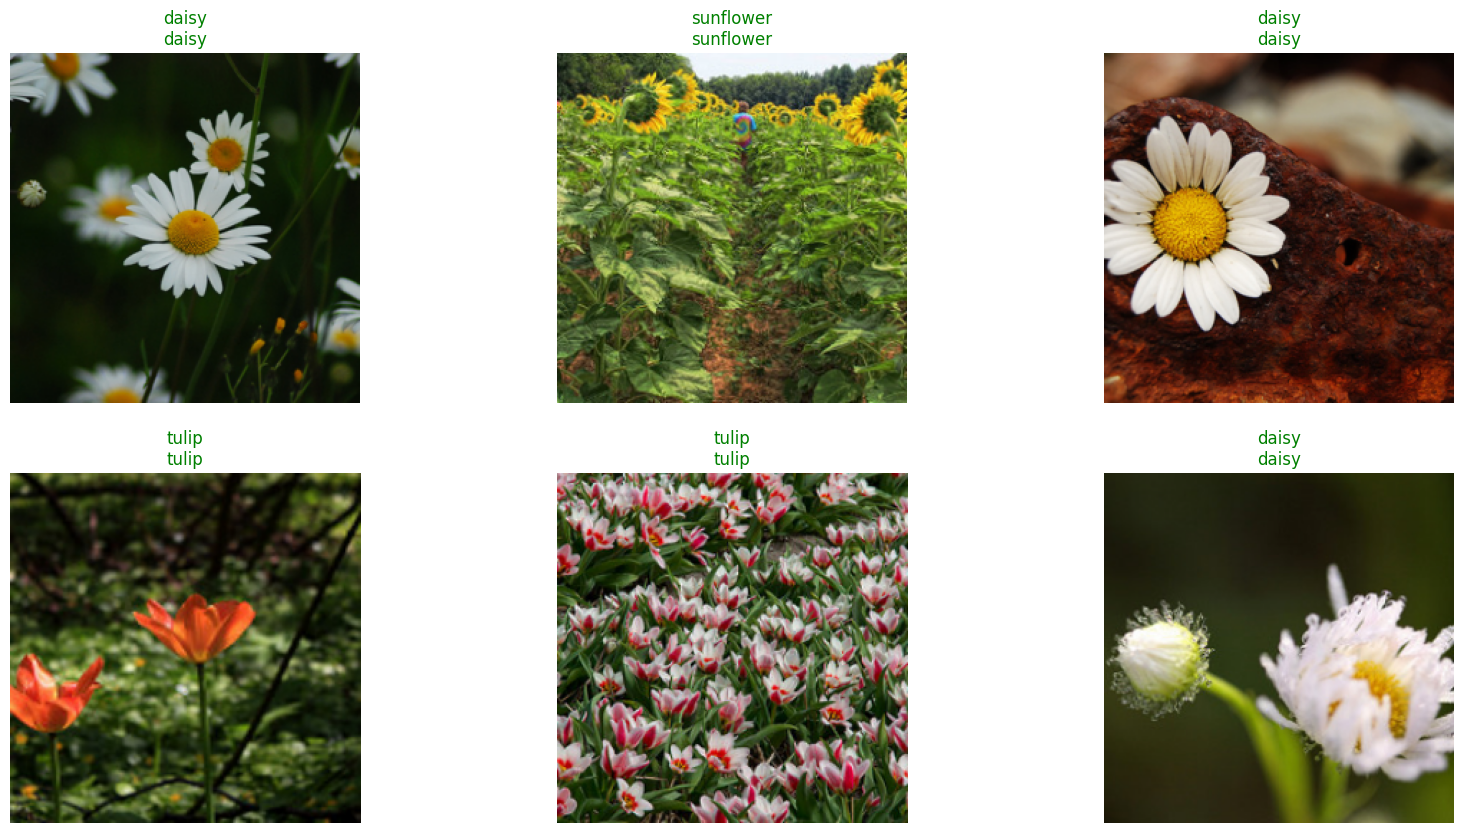

In [54]:
get_learner(data, "best_model_stg1").show_results(
    max_n=6, figsize=(20, 10)
)  # Mostra exemplos de resultado do modelo definido

## Determinamos o novo learning rate para o Finetuning

Running lr_find on frozen layers:


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()



Running lr_find on unfrozen layers:


SuggestedLRs(valley=3.0199516913853586e-05)

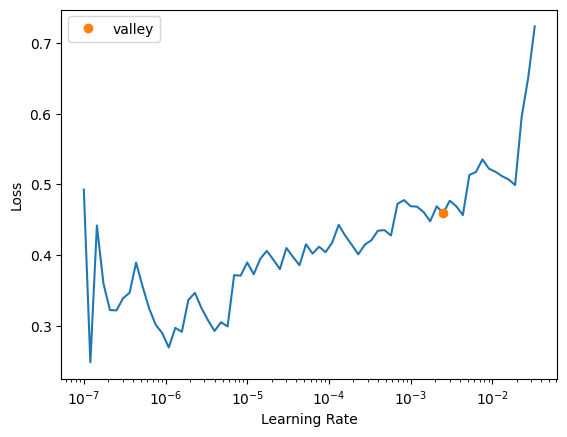

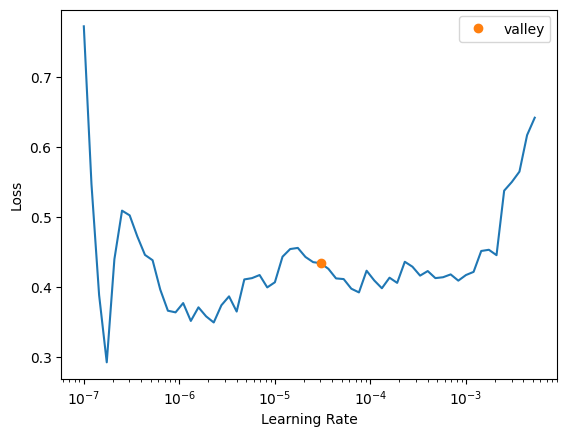

In [55]:
# Load the learner with the best_model_stg1 weights but DO NOT unfreeze yet
learn = get_learner(data, "best_model_stg1", unfreeze=False)

# Run lr_find BEFORE unfreezing to find optimal learning rates for the head
print("Running lr_find on frozen layers:")
learn.lr_find()

# Now, unfreeze the model and run lr_find again
print("\nRunning lr_find on unfrozen layers:")
learn.unfreeze()
learn.lr_find() # You can optionally pass a range like (start_lr, end_lr) based on the first run

#Treinamento do Finetuning

Better model found at epoch 0 with f1_score value: 0.9626823289381656.


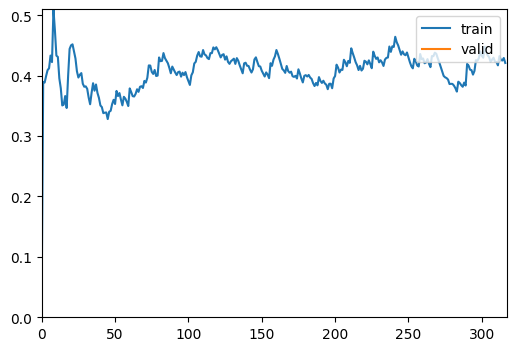

In [56]:
lr = slice(1.5e-5, 5e-4) # nova taxa de aprendizado encontrada
wd = 1e-2
TRAIN_EPOCH = 1
learn = get_learner(data, "best_model_stg1", True) # definir como peso inicial o peso treinado anteriormente
callbacks = [
    SaveModelCallback(monitor="f1_score", fname="best_model_stg2", with_opt=False),
    ShowGraphCallback(),
] # definir um novo nome para o peso do finetuning.

# Iniciar treinamento
learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callbacks)

## Mostramos os resultados

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


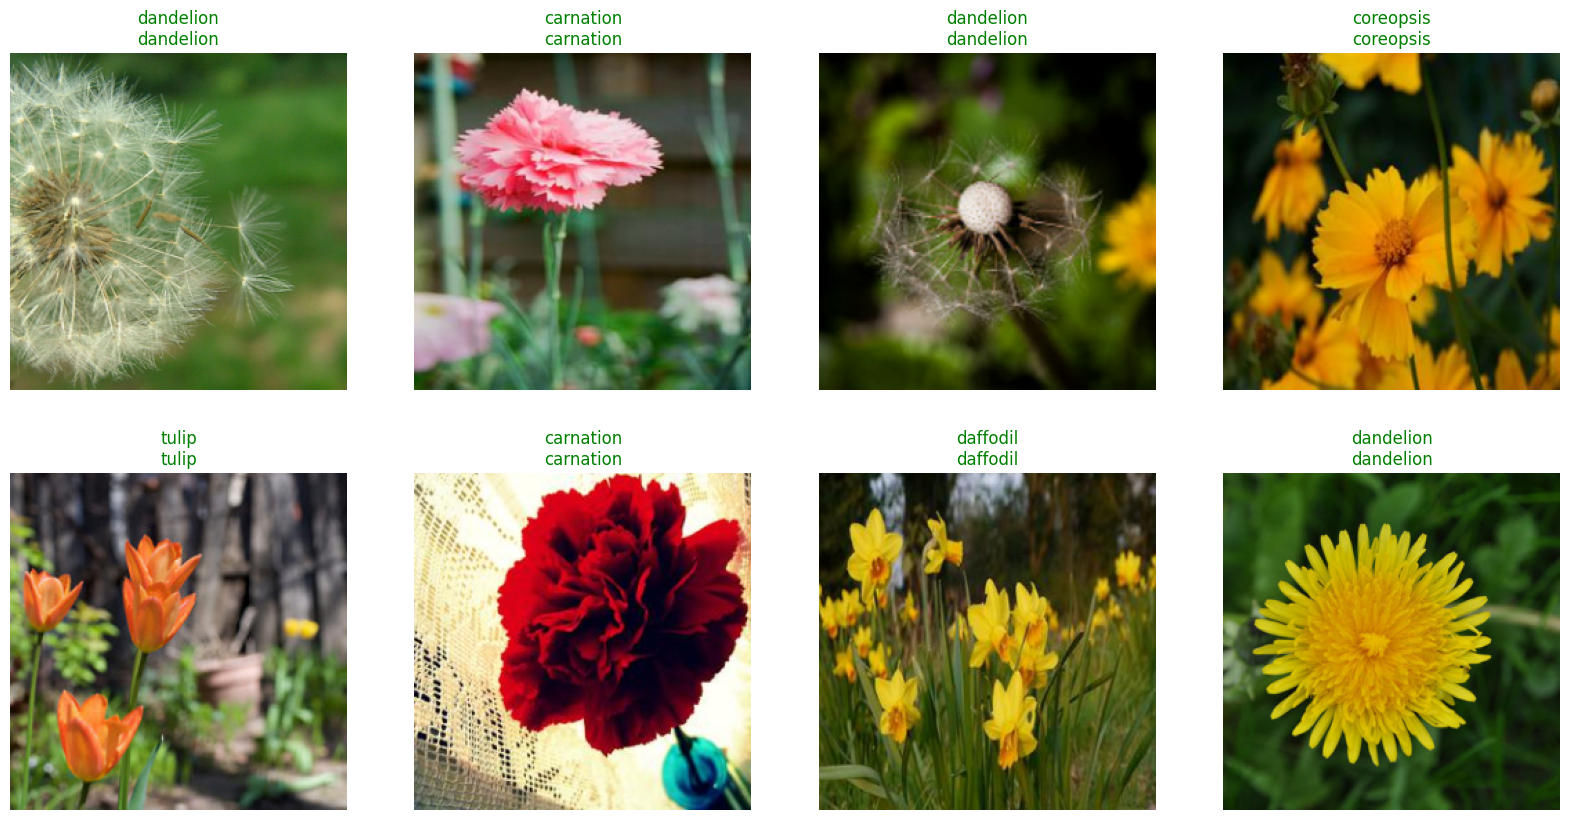

In [58]:
get_learner(data, "best_model_stg2").show_results(max_n=16, figsize=(20, 10))

## Test

Rodamos as evaluations das métricas no test set

In [59]:
bs = 1
path_test = path_dataset / "test"
data_test = ImageDataLoaders.from_folder(path = path_dataset,train='test',valid='test',test = path_test, bs=bs,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),)

In [60]:
learn = get_learner(data_test, "best_model_stg2") # utilizamos como teste o último peso do modelo treinado
ds_test = data_test.valid_ds

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


#Test Functions

In [61]:
from IPython.display import Image
# Iterators to convert to the LapixDL input format

def gt_classifications(ds):
    for (img, cls) in ds:
        yield Classification(int(cls))


def pred_classifications(ds):
    for (img, cls) in ds:
        (cls_name, pred_cls, scores) = learn.predict(img)
        yield Classification(int(pred_cls), scores[int(pred_cls)])


def top5(img):
  pred_class, pred_idxs, outputs = learn.predict(img)
  top_5_conf, i = outputs.topk(5)
  itr = 0
  classes = data.classes
  for x in i:
    print("Class: %s, Probability: %.4f %%"%(classes[x.item()], top_5_conf[itr].item()*100))
    itr=itr+1
  print()

def get_prediction(img,correct):
  pred_class, pred_idxs, outputs = learn.predict(img)
  classes = data.classes
  out = list(outputs)
  index = classes.index(correct)
  prediction = out[index]
  print("%.10f %%"%(prediction.item()*100))
  print()

In [62]:
evaluation_test = evaluate_classification(
    gt_classifications(ds_test), pred_classifications(ds_test), ds_test.vocab
)

0 samples [00:00, ? samples/s]

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


#Plotamos a matriz de confusão

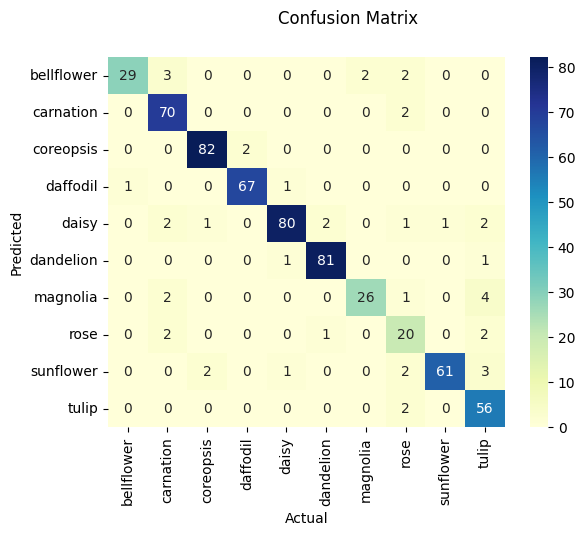

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Actual', ylabel='Predicted'>)

In [63]:
evaluation_test.show_confusion_matrix()